In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os

In [36]:
resampled_dir = "../data/resampled/"
resampled_file_path = os.path.join(resampled_dir, "usdjpy-bar-test-2020-01-01-2024-12-31.pkl")
# resampled_file_path = os.path.join(resampled_dir, "usdjpy-bar-2020-01-01-2024-12-31.csv")

In [37]:
df = pd.read_pickle(resampled_file_path)
df.head()

,timestamp,open,high,low,close,volume
0,2020-01-01 22:00:00,108.7580,108.7600,108.7580,108.7590,9179.999948
1,2020-01-01 22:01:00,108.7570,108.7590,108.7495,108.7495,13300.000012
2,2020-01-01 22:02:00,108.7495,108.7535,108.7495,108.7535,4500.000000
3,2020-01-01 22:03:00,108.7540,108.7555,108.7535,108.7555,10490.000010
4,2020-01-01 22:04:00,108.7575,108.7650,108.7555,108.7650,11600.000024


# Sample smaller dataset

In [40]:
df = df[df['timestamp'].dt.year == 2024]
df.shape

(525600, 6)

# Dealing with NaN value

In [41]:
df.isna().sum()

timestamp         0
open         153537
high         153537
low          153537
close        153537
volume            0
dtype: int64

In [42]:
df = df.dropna()
df.isna().sum()

timestamp    0
open         0
high         0
low          0
close        0
volume       0
dtype: int64

In [43]:
df.shape

(372063, 6)

# Time grouping

By examining the data, we found that there are timeframes that only include Nan values. After clearing those NaN values, our time series data is no longer continuous, i.e. there're *time gaps*. Therefore, we need to group the data by checking their time continuity and assign *time_group* labels accordingly. This is a necessary process prior to the creation of sequences since *time gaps* can be huge and we don't want to create sequences or calculate indicators across them.

In [44]:
# Ensure df is a copy (not a view)
df = df.copy()

# Then assign safely
df.loc[:, 'timestamp'] = pd.to_datetime(df['timestamp'])
df.loc[:, 'time_delta'] = df['timestamp'].diff().dt.total_seconds()
df.loc[:, 'time_group'] = (df['time_delta'] != 60).cumsum().astype(int)
df = df.drop(columns='time_delta')

In [45]:
df.isna().sum()

timestamp     0
open          0
high          0
low           0
close         0
volume        0
time_group    0
dtype: int64

In [46]:
df[['timestamp', 'time_group']]

,timestamp,time_group
2103840,2024-01-01 22:00:00,1
2103841,2024-01-01 22:01:00,1
2103842,2024-01-01 22:02:00,1
2103843,2024-01-01 22:03:00,1
2103845,2024-01-01 22:05:00,2
...,...,...
2628115,2024-12-30 23:55:00,998
2628116,2024-12-30 23:56:00,998
2628117,2024-12-30 23:57:00,998
2628118,2024-12-30 23:58:00,998


In [47]:
df['time_group'].value_counts().sort_index()

time_group
1       4
2       2
3       2
4       3
5      13
       ..
994     1
995     1
996     1
997    28
998    35
Name: count, Length: 998, dtype: int64

# Feature engineering

## Add delta and return

The original price data is non-stationary, we can convert it into stationary data by calculating the difference between each timeframe as *delta* value.
And we are also adding *return* values that indicates the percentage of grow/drop from the last timeframe.
We will do the following process:
1. calculate delta and returns within each timegroup, note that this will result in adding 1 NaN value for each time group and will be dropped later on.
2. labeling the moving **direction** for each row based on the **return** and a given **threshold**
    ```
    'up' if x > threshold else ('down' if x < -threshold else 'flat')
    ```
3. use a global encoder to encode the **direction**, this column will later on be used as target to train our model.

In [48]:
GROUP_COl = 'time_group'

In [49]:
import numpy as np

def add_delta(df, price_col: str = 'close', group_col: str = 'time_group') -> pd.DataFrame:
    df = df.copy()

    def calc(group):
        group[f"{price_col}_delta"] = group[price_col] - group[price_col].shift(1)
        group[f"{price_col}_return"] = group[price_col] / group[price_col].shift(1) - 1
        return group

    df = df.groupby(group_col, group_keys=False).apply(calc)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    return df.reset_index(drop=True)


In [50]:
df = add_delta(df)

C:\Users\yoyo\AppData\Local\Temp\ipykernel_28540\3694927910.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(group_col, group_keys=False).apply(calc)


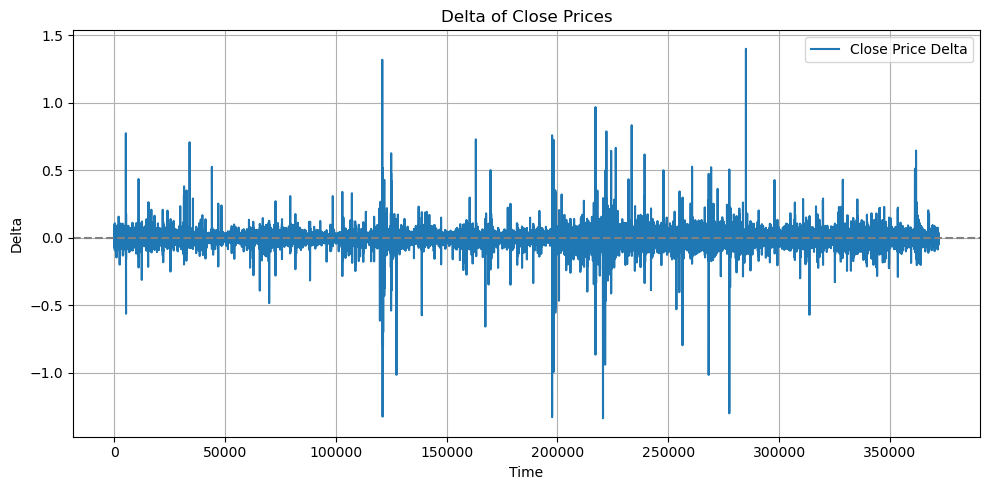

In [51]:
# Plot the delta
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['close_delta'], label='Close Price Delta')
plt.axhline(0, color='gray', linestyle='--')  # zero line
plt.title('Delta of Close Prices')
plt.xlabel('Time')
plt.ylabel('Delta')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [52]:
df[100:105]

,timestamp,open,high,low,close,volume,time_group,close_delta,close_return
100,2024-01-01 23:51:00,141.0700,141.0720,141.0665,141.0680,77560.001850,7,0.0040,0.000028
101,2024-01-01 23:52:00,141.0670,141.0900,141.0670,141.0860,289800.005913,7,0.0180,0.000128
102,2024-01-01 23:53:00,141.0870,141.0975,141.0785,141.0865,194920.003772,7,0.0005,0.000004
103,2024-01-01 23:54:00,141.0895,141.1140,141.0795,141.1110,441240.005374,7,0.0245,0.000174
104,2024-01-01 23:55:00,141.1095,141.1165,141.1060,141.1155,329750.000000,7,0.0045,0.000032


In [53]:
df['time_group'].value_counts().sort_index()

time_group
1       4
2       2
3       2
4       3
5      13
       ..
994     1
995     1
996     1
997    28
998    35
Name: count, Length: 998, dtype: int64

## Plot histgram

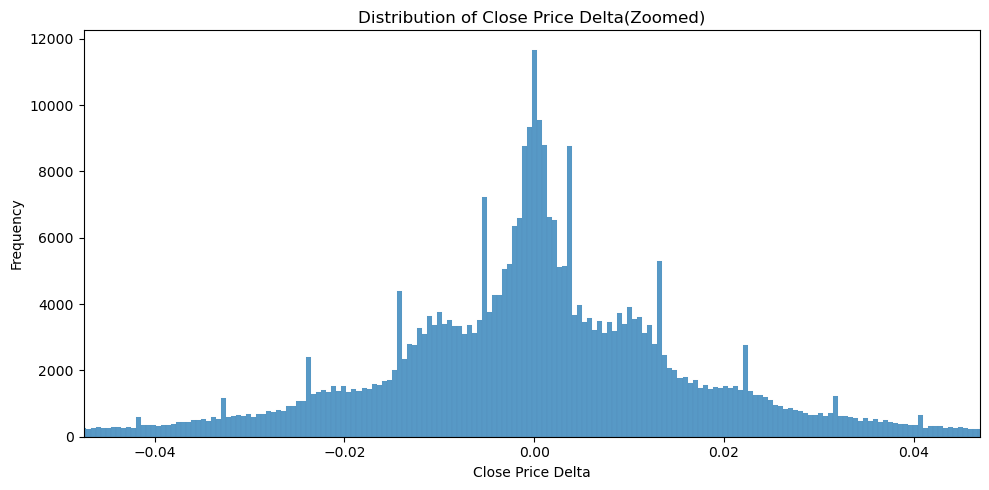

In [54]:
import seaborn as sns

df_copy = df.copy()

low, high = df_copy['close_delta'].quantile([0.025, 0.975])  # 95% range

plt.figure(figsize=(10, 5))
sns.histplot(df_copy['close_delta'])
plt.title("Distribution of Close Price Delta(Zoomed)")
plt.xlabel("Close Price Delta")
plt.ylabel("Frequency")
plt.xlim(low, high)
plt.tight_layout()
plt.show()

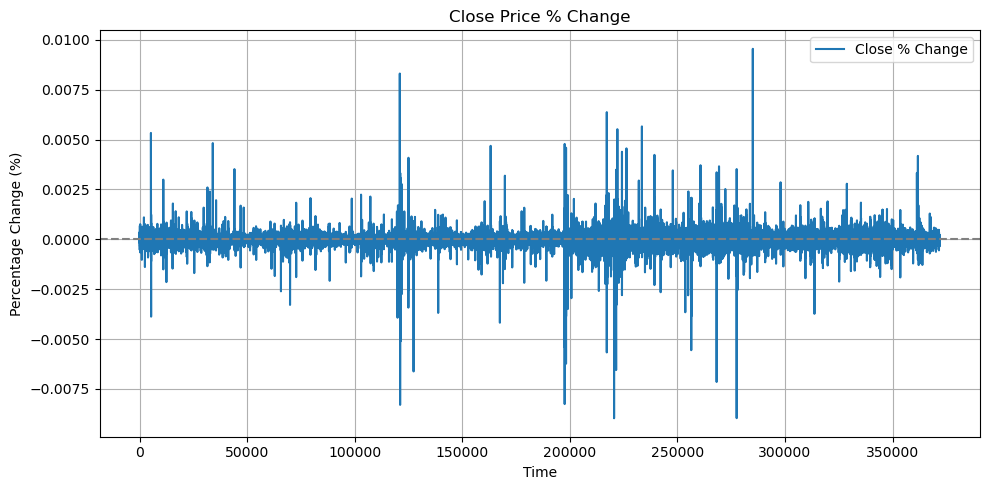

In [55]:
# Plot percentage change
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['close_return'], linestyle='-', label='Close % Change')
plt.axhline(0, color='gray', linestyle='--')

# Formatting
plt.title('Close Price % Change')
plt.xlabel('Time')
plt.ylabel('Percentage Change (%)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

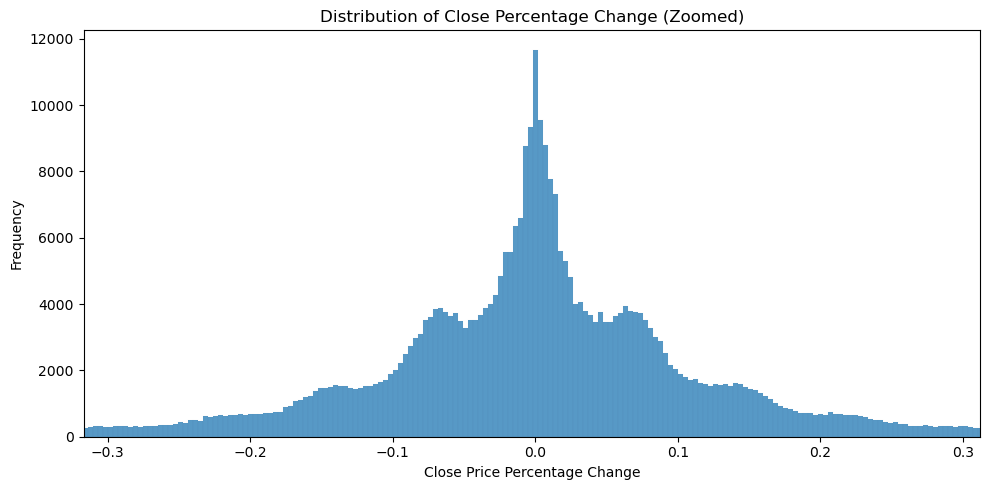

In [56]:
df_copy = df.copy()

low, high = (df_copy['close_return']*1000).quantile([0.025, 0.975])  # 95% range

plt.figure(figsize=(10, 5))
sns.histplot(df_copy['close_return']*1000)
plt.title("Distribution of Close Percentage Change (Zoomed)")
plt.xlabel("Close Price Percentage Change")
plt.ylabel("Frequency")
plt.xlim(low, high)
plt.tight_layout()
plt.show()



In [57]:
df.isna().sum()

timestamp         0
open              0
high              0
low               0
close             0
volume            0
time_group        0
close_delta     998
close_return    998
dtype: int64

In [58]:
df = df.dropna()
df.isna().sum()

timestamp       0
open            0
high            0
low             0
close           0
volume          0
time_group      0
close_delta     0
close_return    0
dtype: int64

## Classification Labeling

## Add direction

In [59]:
def add_direction(df, delta_columns=['close'], threshold=0.005):
    """
    Add directional class labels based on deltas and a threshold.
    """
    df = df.copy()
    
    for col in delta_columns:
        df[f"{col}_direction"] =  df[f"{col}_return"].apply(lambda x: 'up' if x > threshold else ('down' if x < -threshold else 'flat'))
    return df

In [60]:
df = add_direction(df, threshold=3e-5)

In [61]:
df['close_direction'].value_counts()

close_direction
up      128663
down    125736
flat    116666
Name: count, dtype: int64

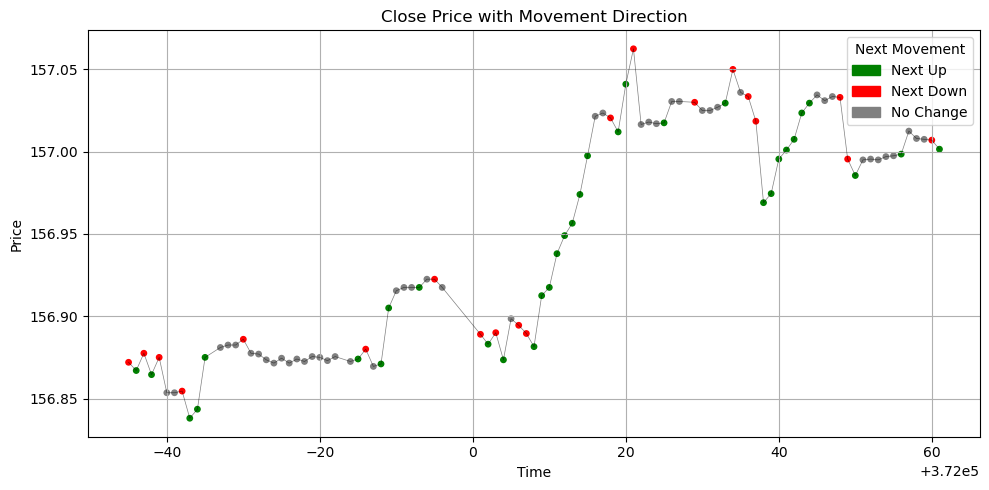

In [62]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Slice and shift for next movement direction
df_filtered = df[-101:].copy()
df_filtered['next_direction'] = df_filtered['close_direction'].shift(-1)
df_filtered = df_filtered[:-1]  # Drop the last row where next_direction is NaN

# Plot
plt.figure(figsize=(10, 5))

# Color map
colors = df_filtered['next_direction'].map({'up': 'green', 'down': 'red', 'flat': 'gray'})

# Plot scatter and line
plt.scatter(df_filtered.index, df_filtered['close'], c=colors, s=15)
plt.plot(df_filtered.index, df_filtered['close'], color='black', linewidth=0.5, alpha=0.5)

# Create manual legend
legend_patches = [
    mpatches.Patch(color='green', label='Next Up'),
    mpatches.Patch(color='red', label='Next Down'),
    mpatches.Patch(color='gray', label='No Change'),
]
plt.legend(handles=legend_patches, title='Next Movement')

# Final formatting
plt.title('Close Price with Movement Direction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.tight_layout()
plt.show()


In [63]:
df.head()

,timestamp,open,high,low,close,volume,time_group,close_delta,close_return,close_direction
1,2024-01-01 22:01:00,140.8720,140.8720,140.8720,140.8720,1399.999976,1,0.0000,0.000000,flat
2,2024-01-01 22:02:00,140.8705,140.8705,140.8705,140.8705,1399.999976,1,-0.0015,-0.000011,flat
3,2024-01-01 22:03:00,140.8655,140.8655,140.8655,140.8655,1399.999976,1,-0.0050,-0.000035,down
5,2024-01-01 22:06:00,140.8670,140.8670,140.8670,140.8670,2100.000024,2,0.0010,0.000007,flat
7,2024-01-01 22:11:00,140.8670,140.8950,140.8670,140.8670,13920.000225,3,-0.0175,-0.000124,down


## Label encoding

In [64]:
from sklearn.preprocessing import LabelEncoder

def add_label(df, class_col='direction'):
    """
    Add directional class labels based on deltas and a threshold.
    """
    df = df.copy()
    
    label_encoder = LabelEncoder()
    df["label"] = label_encoder.fit_transform(df[class_col])
    direction_counts = df["label"].value_counts()
    print(direction_counts)
    print(label_encoder.classes_)
    return df, label_encoder

In [65]:
df, encoder = add_label(df, class_col='close_direction')

label
2    128663
0    125736
1    116666
Name: count, dtype: int64
['down' 'flat' 'up']


In [66]:
import joblib

ENCODER_PATH = '../data/processed/label_encoder.pkl'

joblib.dump(encoder, ENCODER_PATH)

['../data/processed/label_encoder.pkl']

In [67]:
df.head()

,timestamp,open,high,low,close,volume,time_group,close_delta,close_return,close_direction,label
1,2024-01-01 22:01:00,140.8720,140.8720,140.8720,140.8720,1399.999976,1,0.0000,0.000000,flat,1
2,2024-01-01 22:02:00,140.8705,140.8705,140.8705,140.8705,1399.999976,1,-0.0015,-0.000011,flat,1
3,2024-01-01 22:03:00,140.8655,140.8655,140.8655,140.8655,1399.999976,1,-0.0050,-0.000035,down,0
5,2024-01-01 22:06:00,140.8670,140.8670,140.8670,140.8670,2100.000024,2,0.0010,0.000007,flat,1
7,2024-01-01 22:11:00,140.8670,140.8950,140.8670,140.8670,13920.000225,3,-0.0175,-0.000124,down,0


# Timegroup Filtering

Before creating sequences, we have to make sure every **time group** have enough data to create at least **1** sequence.
Given the sequence length is X, horizon is H, each time group must have at least X + H timeframes. 

In [68]:
SEQ_LEN = 30
HORIZON = 1

min_len = SEQ_LEN + HORIZON
df = df.groupby("time_group").filter(lambda g: len(g) >= min_len)

In [69]:
df['time_group'].nunique()

403

In [70]:
df['time_group'].value_counts()

time_group
19     5703
71     4370
32     4317
13     4314
10     2936
       ... 
413      32
856      32
599      32
879      31
390      31
Name: count, Length: 403, dtype: int64

# Saving the file

In [71]:
PROCESSED_DIR = "../data/processed/"
PROCESSED_FILENAME = "usdjpy-bar-2024-01-01-2024-12-31_processed.pkl"
PROCESSED_FILE_PATH = os.path.join(PROCESSED_DIR, PROCESSED_FILENAME)

df.to_pickle(PROCESSED_FILE_PATH)